# LGT2 Unit11 Day03 - In-Class Assignment: Generalized Parton Distributions from Lattice QCD

in the Asymmetric Frame
### <p style="text-align: right;"> &#9989; Put your name here.</p>
#### <p style="text-align: right;"> &#9989; Put your group member names here.</p>

---
## Goals of this assignment

The goals of this assignment are:

* Learn how to extract the $A_i$ GPD amplitudes from the $\Pi_\kappa(\Gamma_\mu)$ matrix elements at zero skewness
* Utilize the symmetries of the $A_i$ to obtain the spatial quasi-GPDs $H$ and $E$
* Learn about how we do fourier transforms on the discrete and finite distance data to get the quasi-GPDs

## Assignment instructions

Work with your group to complete this assignment. Upload the assignment to each university's assignement system at the end of class.
The class has a diverse background of students with different experties; if the topic aligned well with your research topic, help the instructor to guide other students who learn about these topics for the very first time. There will be classes that others are the experts and can return the favor.
**Make sure everyone's name is listed in everyone's notebook before moving on**

---
# Part 1: Extracting the GPD Amplitudes from Lattice Matrix Elements
Recall from the pre-class assignment that we can obtain the $H$ and $E$ GPDs from asymmtric frame lattice matrix elements
$$\Pi_\mu(\Gamma_\kappa)(z, P_3, \vec{\Delta}) = {\rm Tr}\Big[\Gamma_\kappa \, \Lambda(p) \, F_\mu \Lambda(p) \Big]\,, \quad \mu, \kappa=0,1,2,3\,,
$$
where
$$F^{\mu}(z, P, \Delta)  = \langle p_f | \bar{q} (-\tfrac{z}{2}) \gamma^\mu \, {\cal W}(-\tfrac{z}{2}, \tfrac{z}{2})  q (\tfrac{z}{2}) | p_i\rangle $$.

These matrix elements are related to linear combinations of the 8 $A_i$ amplitudes, which are given by Eqs. (73-88) of [arXiv:2209.05373v2](https://arxiv.org/pdf/2209.05373).
At zero skewness, the amplitudes define the spatial quasi-GPDs as
$$H(z) = A_1$$
and
$$E(z) = -A_1 + 2A_5 +2zP_3 A_6$$

We have obtained and resampled asymmetric frame GPD matrix elements
from the authors of [arXiv:2209.05373v2](https://arxiv.org/pdf/2209.05373).
These matrix elements are sampled on an esemble with $L^3 \times T = 32^3 \times 64$, a lattice spacing $a \approx 0.09$ fm, and $M_\pi \approx 260$ MeV.
We have matrix elements for $z \in [-15a,15a]$, $P_3 = \pm 3$, and $\vec{\Delta} = (\pm 2, 0,0),~(0,\pm 2, 0)$ (both in units $\frac{2\pi}{L}$)

In this section, we will start by reading in the $\Pi_\mu(\Gamma_\kappa)$.
From the matrix elements $\Pi_0(\Gamma_{0,1,2,3})$,
$\Pi_1(\Gamma_{0,2,3})$, $\Pi_2(\Gamma_{0,1,3})$, we will extract the amplitudes $A_{1,3-6,8}$ for all 8 combinations of $P_3$ and $\vec{\Delta}$.
We will then consider the symmetry properties of the $A_i$ to obtain a single set of $A_i(z)$, which we will then use to constuct the spatial quasi-GPDs.

Note: $A_{2,7}$ are not necessary to extract the GPDs, and only come in from the parameterizations of $\Pi_3(\Gamma_\kappa)$, so we won't explore those.

## Data Policy
Note that the data will be used for this class's exercise only.
The data that we provide was resampled from the mean and error of the original matrix elements. Since we have neglected correlations, we will not reproduce the results exactly.
To use the data outside this class, reach out to Martha Constantinou (marthac@temple.edu) to get collaboration's permission.

In [1]:
#Libraries and stuff to include
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
from tqdm import tqdm

## Step 1.1: Read in the Matrix elements
We have 269 bootstrap samples of the matrix elements at each value of $\Pi_\mu(\Gamma_\kappa)(z, P_3, \vec{\Delta})$
We begin by reading in the arrays of matrix elements from the HDF5 files.
The code below puts the matrix element arrays into a nested dictionary with the key $(\mu, \kappa, P_3, \vec{\Delta})$ at the first layer and $z$ at the second layer.


In [2]:
# Thanks to Alex NieMiera for helping me with the HDF5 reading and dictionary structuring!

ME = {}

start_time = time.time()
with h5py.File("data.h5", "r") as f:
    for mu_key in f.keys():  # Pi_mu
        mu = int(mu_key.split("_")[1])

        for kappa_key in f[mu_key].keys():  # gamma_kappa
            kappa = int(kappa_key.split("_")[1])

            for p_key in f[mu_key][kappa_key].keys():  # px0_py0_pz{p3}
                p3 = int(p_key.split("_pz")[-1])

                for delta_key in f[mu_key][kappa_key][p_key].keys():  # delta1_dx_dy_dz or delta2_dx_dy_dz
                    parts = delta_key.split("_")
                    delta_type = parts[0]
                    dx, dy, dz = map(int, parts[1:])
                    delta_tuple = (dx, dy, dz)
                    MEzs = {}
                    for z_key in f[mu_key][kappa_key][p_key][delta_key].keys():
                        z = int(z_key[1:])
                        MEzs[z] = np.array(list(f[mu_key][kappa_key][p_key][delta_key][z_key]["ME"][:]))

                    ME[(mu, kappa, p3, delta_tuple)] = MEzs
end_time = time.time()
print(f"Time to create dictionary: {end_time - start_time:.4f} seconds")

N_samples = len(ME[(0, 0, -3, (-2, 0, 0))][0])
print(f'Number of samples: {N_samples}')

Time to create dictionary: 2.2224 seconds
Number of samples: 269


In [3]:
# Take a look at the keys. Which ones are missing? Does this make sense based on Eqs. (73-84) from arXiv:2209.05373v2?
print('(mu, kappa, P_3, Delta)')
for key in ME.keys():
    print(f'({key[0]}, {key[1]}, {key[2]:>2}, ({key[3][0]:>2}, {key[3][1]:>2}, {key[3][2]}))')

(mu, kappa, P_3, Delta)
(0, 0, -3, (-2,  0, 0))
(0, 0, -3, ( 2,  0, 0))
(0, 0, -3, ( 0, -2, 0))
(0, 0, -3, ( 0,  2, 0))
(0, 0,  3, (-2,  0, 0))
(0, 0,  3, ( 2,  0, 0))
(0, 0,  3, ( 0, -2, 0))
(0, 0,  3, ( 0,  2, 0))
(0, 1, -3, ( 0, -2, 0))
(0, 1, -3, ( 0,  2, 0))
(0, 1,  3, ( 0, -2, 0))
(0, 1,  3, ( 0,  2, 0))
(0, 2, -3, (-2,  0, 0))
(0, 2, -3, ( 2,  0, 0))
(0, 2,  3, (-2,  0, 0))
(0, 2,  3, ( 2,  0, 0))
(1, 0, -3, (-2,  0, 0))
(1, 0, -3, ( 2,  0, 0))
(1, 0,  3, (-2,  0, 0))
(1, 0,  3, ( 2,  0, 0))
(1, 2, -3, (-2,  0, 0))
(1, 2, -3, ( 2,  0, 0))
(1, 2, -3, ( 0, -2, 0))
(1, 2, -3, ( 0,  2, 0))
(1, 2,  3, (-2,  0, 0))
(1, 2,  3, ( 2,  0, 0))
(1, 2,  3, ( 0, -2, 0))
(1, 2,  3, ( 0,  2, 0))
(1, 3, -3, ( 0, -2, 0))
(1, 3, -3, ( 0,  2, 0))
(1, 3,  3, ( 0, -2, 0))
(1, 3,  3, ( 0,  2, 0))
(2, 0, -3, ( 0, -2, 0))
(2, 0, -3, ( 0,  2, 0))
(2, 0,  3, ( 0, -2, 0))
(2, 0,  3, ( 0,  2, 0))
(2, 1, -3, (-2,  0, 0))
(2, 1, -3, ( 2,  0, 0))
(2, 1, -3, ( 0, -2, 0))
(2, 1, -3, ( 0,  2, 0))
(2, 1,  3, (-2, 

### Task 1.1.1: Group Discussion
Not every combination of the key is present, as some choices of $\mu, \kappa$ project to 0 for a given $\vec{\Delta}$.
Can you make a list of the missing $\mu, \kappa, \vec{\Delta}$ combinations?
Check if this is in line with Eqs. (73-84) of [arXiv:2209.05373v2](https://arxiv.org/pdf/2209.05373)

\[Your notes here\]

## Step 1.2: Plot the Matrix Elements
In this step, we will plot the matrix elements and make observations.
You do not need to write any code here.

In [4]:
fcolorlist = ['none', 'blue', 'none', 'cyan', 'none', 'red', 'none', 'orange']
edgecolorlist = ['blue', 'blue', 'cyan', 'cyan', 'red', 'red', 'orange', 'orange']
markers = ['s', 's','^', '^', 'o', 'o', 'd', 'd']


def quick_stats(arr, **kwargs):
  ''' Quick function to return the mean and error for elements in an array'''
  return np.mean(arr, **kwargs), np.std(arr, **kwargs)

def plot_matrix_elements(zs, ME_mean_errs, key_list, ylab = 'ME'):
  ''' This function plots the matrix elements with error bars
  in a given list of keys '''
  plt.figure()
  for i, key in enumerate(key_list):
    plt.errorbar(zs, ME_mean_errs[i, 0], yerr = ME_mean_errs[i,1], markerfacecolor = fcolorlist[i],
                 markeredgecolor = edgecolorlist[i], fmt = markers[i], ecolor = edgecolorlist[i],
                 label = f'({key[0]}, {key[1]}, {key[2]:>2}, ({key[3][0]:>2}, {key[3][1]:>2}, {key[3][2]}))')
  plt.xlabel(r'$z/a$')
  plt.ylabel(ylab)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()

In [5]:
# Making a list of the mean and the error for the real and imaginary parts of all the MEs

ME_real_mean_errs = {}
ME_imag_mean_errs = {}

zs = np.arange(-15, 16)

for key in ME.keys():
    ME_real = np.array([np.real(ME[key][z]) for z in zs])
    ME_imag = np.array([np.imag(ME[key][z]) for z in zs])
    ME_real_mean_errs[key] = quick_stats(ME_real, axis = 1)
    ME_imag_mean_errs[key] = quick_stats(ME_imag, axis = 1)


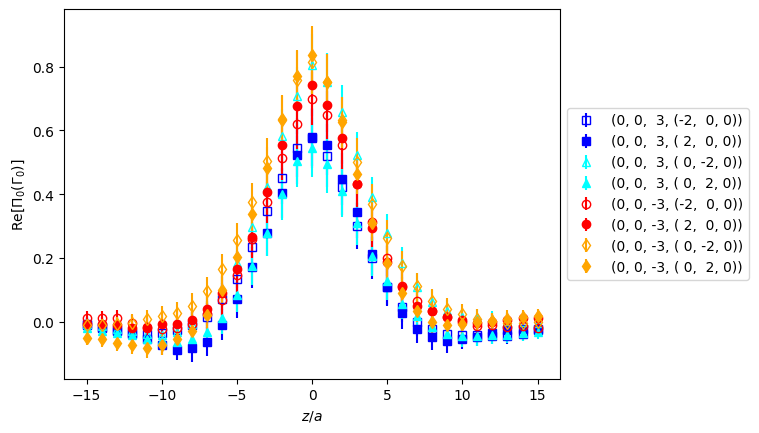

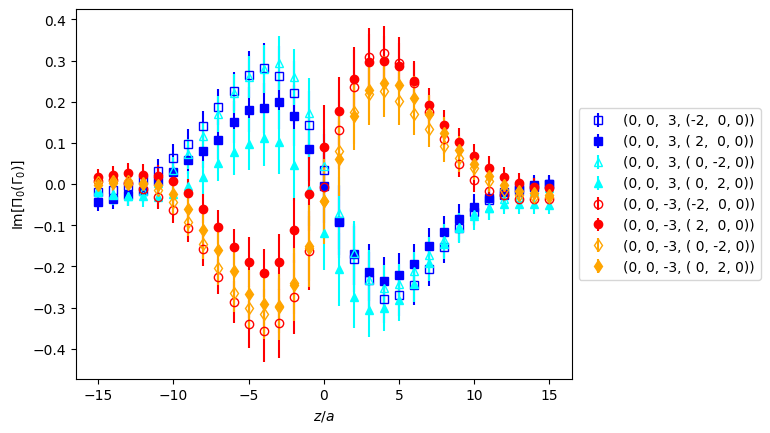

In [6]:
#Plot of the 00 matrix elements
keys00 = [(0, 0, 3, (-2,  0, 0)), (0, 0,  3, ( 2,  0, 0)), (0, 0,  3, ( 0, -2, 0)),
         (0, 0,  3, ( 0,  2, 0)), (0, 0, -3, (-2,  0, 0)), (0, 0, -3, ( 2,  0, 0)),
         (0, 0, -3, ( 0, -2, 0)), (0, 0, -3, ( 0,  2, 0))]


MEs00_real = np.array([ME_real_mean_errs[key] for key in keys00])
MEs00_imag = np.array([ME_imag_mean_errs[key] for key in keys00])

plot_matrix_elements(zs, MEs00_real, keys00, r'Re$[\Pi_0(\Gamma_0)]$')
plot_matrix_elements(zs, MEs00_imag, keys00, r'Im$[\Pi_0(\Gamma_0)]$')

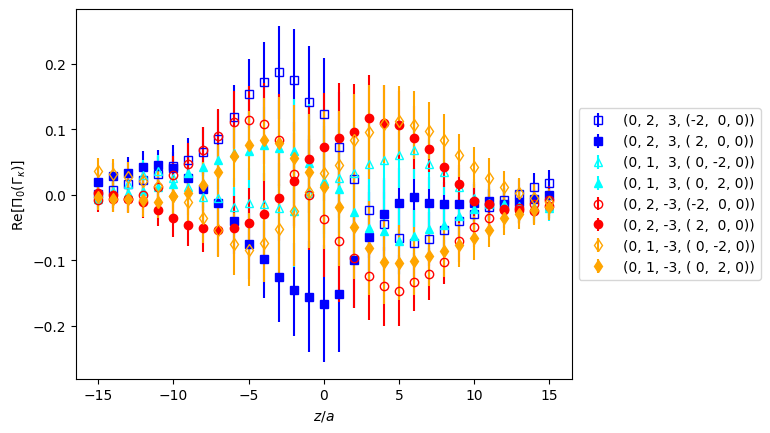

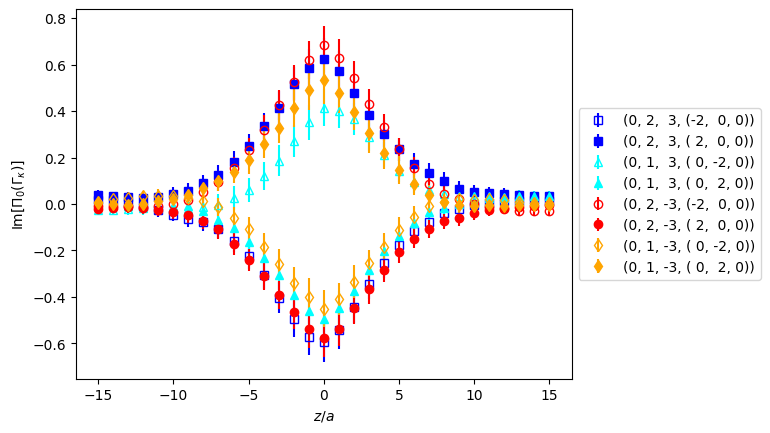

In [7]:
#Plot of the 0 1,2 matrix elements

### NOTE: These plots are flipped from what is in the paper due to Euclidean to Minkowski space conventions. ###

keys0_12 = [(0, 2,  3, ( -2,  0, 0)),
            (0, 2,  3, (  2,  0, 0)),
            (0, 1,  3, (  0, -2, 0)),
            (0, 1,  3, ( 0,  2, 0)),
            (0, 2, -3, ( -2, 0, 0)),
            (0, 2, -3, ( 2, 0, 0)),
            (0, 1, -3, (  0,  -2, 0)),
            (0, 1, -3, ( 0,  2, 0))]

MEs0_12_real = np.array([ME_real_mean_errs[key] for key in keys0_12])
MEs0_12_imag = np.array([ME_imag_mean_errs[key] for key in keys0_12])

plot_matrix_elements(zs, MEs0_12_real, keys0_12, r'Re$[\Pi_0(\Gamma_\kappa)]$')
plot_matrix_elements(zs, MEs0_12_imag, keys0_12, r'Im$[\Pi_0(\Gamma_\kappa)]$')

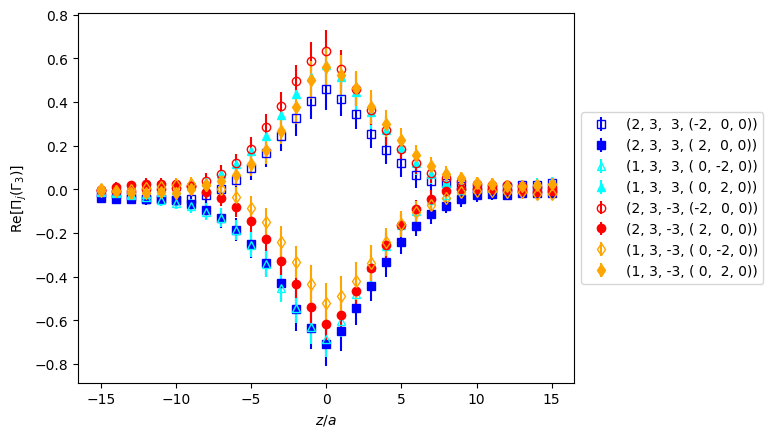

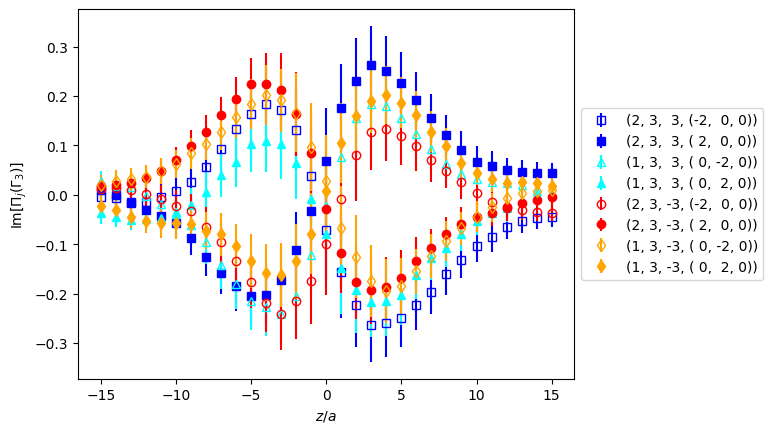

In [8]:
#Plot of the 23 and 13 matrix elements

keysj_3 = [(2, 3,  3, ( -2, 0, 0)),
            (2, 3,  3, ( 2,  0, 0)),
            (1, 3,  3, (0,  -2, 0)),
            (1, 3,  3, ( 0,  2, 0)),
            (2, 3, -3, ( -2, 0, 0)),
            (2, 3, -3, ( 2, 0, 0)),
            (1, 3, -3, (0,  -2, 0)),
            (1, 3, -3, ( 0,  2, 0))]

MEsj_3_real = np.array([ME_real_mean_errs[key] for key in keysj_3])
MEsj_3_imag = np.array([ME_imag_mean_errs[key] for key in keysj_3])

plot_matrix_elements(zs, MEsj_3_real, keysj_3, r'Re$[\Pi_j(\Gamma_3)]$')
plot_matrix_elements(zs, MEsj_3_imag, keysj_3, r'Im$[\Pi_j(\Gamma_3)]$')

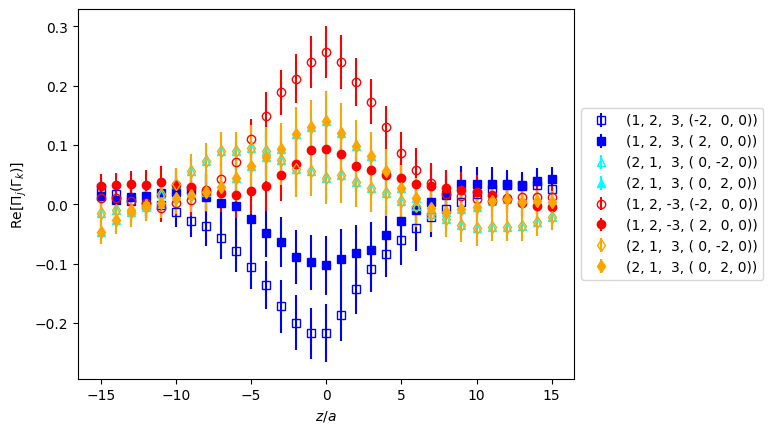

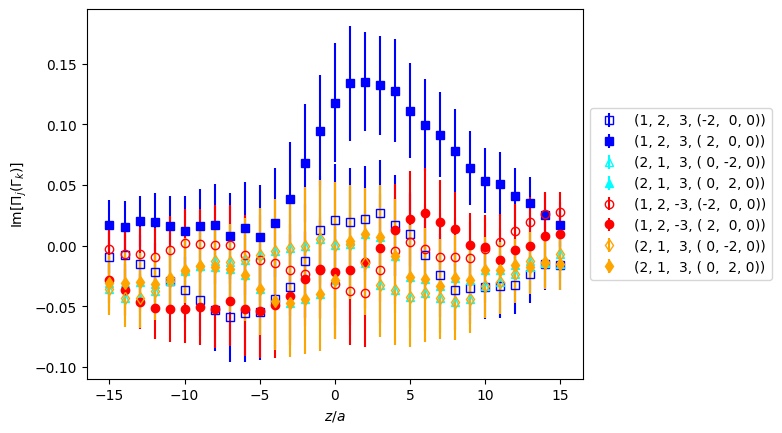

In [9]:
#Plot of the 12 and 21 matrix elements

keysj_k = [(1, 2,  3, (-2,  0, 0)),
           (1, 2,  3, ( 2,  0, 0)),
           (2, 1,  3, ( 0, -2, 0)),
           (2, 1,  3, ( 0,  2, 0)),
           (1, 2, -3, (-2,  0, 0)),
           (1, 2, -3, ( 2,  0, 0)),
           (2, 1,  3, ( 0, -2, 0)),
           (2, 1,  3, ( 0,  2, 0))]

MEsj_k_real = np.array([ME_real_mean_errs[key] for key in keysj_k])
MEsj_k_imag = np.array([ME_imag_mean_errs[key] for key in keysj_k])

plot_matrix_elements(zs, MEsj_k_real, keysj_k, r'Re$[\Pi_j(\Gamma_k)]$')
plot_matrix_elements(zs, MEsj_k_imag, keysj_k, r'Im$[\Pi_j(\Gamma_k)]$')

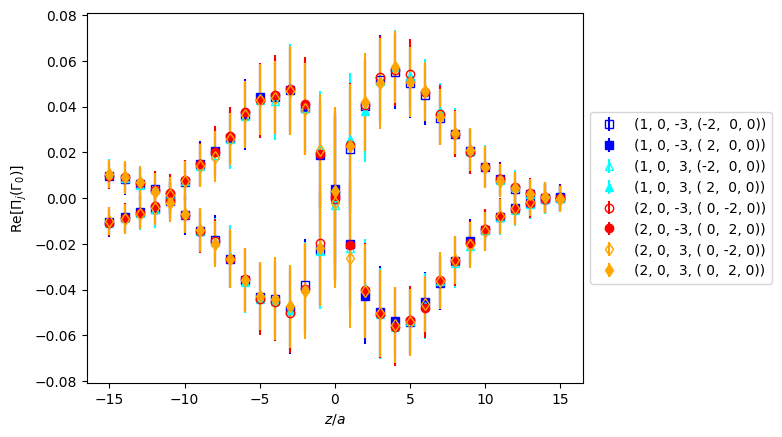

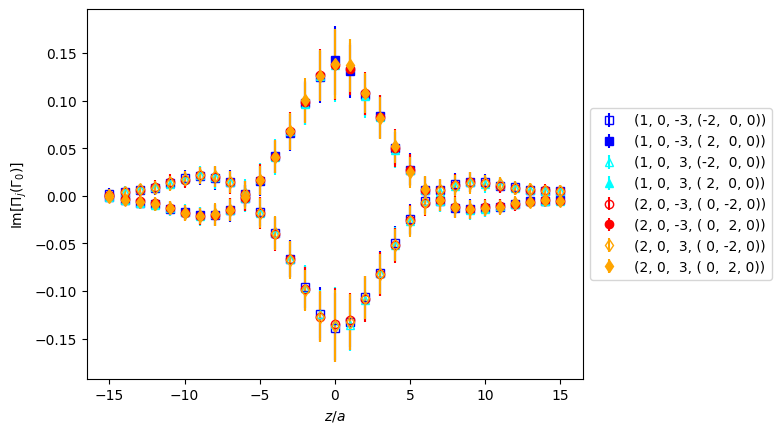

In [10]:
#Plot of the 12 and 21 matrix elements

keysj_0 = [(1, 0, -3, (-2,  0, 0)),
           (1, 0, -3, ( 2,  0, 0)),
           (1, 0,  3, (-2,  0, 0)),
           (1, 0,  3, ( 2,  0, 0)),
           (2, 0, -3, ( 0, -2, 0)),
           (2, 0, -3, ( 0,  2, 0)),
           (2, 0,  3, ( 0, -2, 0)),
           (2, 0,  3, ( 0,  2, 0))]

MEsj_0_real = np.array([ME_real_mean_errs[key] for key in keysj_0])
MEsj_0_imag = np.array([ME_imag_mean_errs[key] for key in keysj_0])

plot_matrix_elements(zs, MEsj_0_real, keysj_0, r'Re$[\Pi_j(\Gamma_0)]$')
plot_matrix_elements(zs, MEsj_0_imag, keysj_0, r'Im$[\Pi_j(\Gamma_0)]$')

### Task 1.2.1: Group Discussion
Comment on the symmetry properties in the matrix elements.

\[Your notes here\]

## Step 1.3: Construct the Amplitudes
In this section, we want to extract the amplitudes from the matrix elements.
The expressions that relate the matrix elements to the amplitudes are quite messy, so I have written the functions to obtain the amplitudes from the matrix elements for a given set of kinematic factors.

It will be your job to use these functions to fill a new nested dictionary with the amplitudes $A_i(P_3, \vec{\Delta}, z)$.

#### Coefficient Matrices
This function handles the expressions that relate the amplitudes to the matrix elements.
Amplitudes that cannot be extracted at $z=0$ are fixed to 0 (this has no effect on the final result because no such amplitude goes into the GPDs at $z=0$)
You do not need to make any edits here.

If you're curious, I took the LaTeX source code for  Eqs. (73-88) of [arXiv:2209.05373v2](https://arxiv.org/pdf/2209.05373) and fed it to ChatGPT in order to write the symbolic expressions as a matrix in Mathematica.
I then used Mathematica to do the inversions for $\vec{\Delta} = (\Delta, 0, 0)$ and $(\Delta, 0, 0)$ and simplify the expression, checking that the $\vec{\Delta} = (\Delta, 0, 0)$ case agrees with Eqs (97-104).
I evaluated the symbolic expression for the variables which are fixed in this calculation and moved them to this notebook.

In [24]:
# some necessary constants
L = 32 #spatial extent of the lattice
m = 0.5 # mass of the proton in units 1/a


def relation_matrix(p3, delta_tuple, z):
  ''' This function takes P3, delta_tuple, and z and returns the matrix
  that gives the linear combinations of Pi_mu(Gamma_kappa) for the A_i's.
  Different matrix elements must be used if delta is in the x direction vs
  the y direction, so different, but related matrices are generated.
  Some amplitudes can't be extracted at z = 0, so those are fixed to 0'''

  #Get everything in units of 1/a
  P3 = p3 * 2 * np.pi / L
  delta1, delta2, delta3 = delta_tuple
  delta1_lat = delta1 * 2 * np.pi / L
  delta2_lat = delta2 * 2 * np.pi / L

  #Final and inital energies
  Ef = np.sqrt(m**2 + P3**2)
  Ei = np.sqrt(m**2 + P3**2 + delta1_lat**2 + delta2_lat**2)

  K = 2*m**2 / np.sqrt(Ei*Ef*(Ef+m)*(Ei+m))

  #if \vec{\Delta} = (\Delta, 0, 0), then we use the following matrix
  if delta2 == 0:
    delta = delta1_lat
    if z != 0: #if not equal to zero, use the full matrix
      M = np.array([[
                     0.47349295261018104,
                     -(((0.0 + 0.0349987948290075j) * P3) / delta),
                     ((0.0 + 0.044540995578587254j) / delta),
                     0.02134910725905038 * P3,
                     0.02134910725905038 * P3,
                     -(0.044540995578587254 / delta)
                    ],
                    [
                     0.23674647630509052,
                     -(((0.0 + 0.01749939741450375j) * P3) / delta),
                     ((0.0 + 0.3881118423431869j) / delta),
                     0.18602730457771144 * P3,
                     0,
                     0
                    ],
                    [
                     0,
                     0,
                     0,
                     0,
                     -(0.9469859052203622 / z),
                     -((0.069997589658015 * P3) / (delta * z))
                    ],
                    [
                     0,
                     0,
                     0,
                     0,
                     0.18602730457771144 * P3,
                     -(0.3881118423431869 / delta)
                    ],
                    [
                     (0.24076725887289188 * P3) / z,
                     -((0.0 + 0.33523469576587955j) / (delta * z)),
                     ((0.0 + 0.022648728674437003j) * P3) / (delta * z),
                     0.20449165497919056 / z,
                     -(0.10191927903496656 / z),
                     (0.6128218680283147 * P3) / (delta * z)
                    ],
                    [
                     (0.12038362943644594 * P3) / z,
                     -((0.0 + 0.16761734788293978j) / (delta * z)),
                     ((0.0 + 0.19735166891492997j) * P3) / (delta * z),
                     1.7818558370063795 / z,
                     1.6286503699993011 / z,
                     (0.12038362943644594 * P3) / (delta * z)]],dtype = complex)
    else:
      M = np.array([[
                     0.47349295261018104,
                     -(((0.0 + 0.0349987948290075j) * P3) / delta),
                     ((0.0 + 0.044540995578587254j) / delta),
                     0.02134910725905038 * P3,
                     0.02134910725905038 * P3,
                     -(0.044540995578587254 / delta)
                    ],
                    [
                     0.23674647630509052,
                     -(((0.0 + 0.01749939741450375j) * P3) / delta),
                     ((0.0 + 0.3881118423431869j) / delta),
                     0.18602730457771144 * P3,
                     0,
                     0
                    ],
                    [0,0,0,0,0,0],
                    [
                     0,
                     0,
                     0,
                     0,
                     0.18602730457771144 * P3,
                     -(0.3881118423431869 / delta)
                    ],
                    [0,0,0,0,0,0],
                    [0,0,0,0,0,0]],dtype = complex)
  else: #Use this matrix if the momentum transfer is in the y direction
    delta = delta2_lat
    if z!= 0: #Can extract all if z!=-
      M = np.array([[
                     0.47349295261018104,
                     ((0.0 + 0.0349987948290075j) * P3) / delta,
                     -0.021349107259050384 * P3,
                     0.044540995578587254 / delta,
                     ((0.0 + 0.044540995578587254j) / delta),
                     -0.021349107259050384 * P3
                    ],
                    [
                     0.23674647630509052,
                     ((0.0 + 0.01749939741450375j) * P3) / delta,
                     0,
                     0,
                     ((0.0 + 0.3881118423431869j) / delta),
                     -0.18602730457771144 * P3
                    ],
                    [
                     0,
                     0,
                     0.9469859052203621 / z,
                     (0.069997589658015 * P3) / (delta * z),
                     0,
                     0
                    ],
                    [
                     0,
                     0,
                     -0.18602730457771144 * P3,
                     0.3881118423431869 / delta,
                     0,
                     0
                    ],
                    [
                     (0.24076725887289188 * P3) / z,
                     ((0.0 + 0.33523469576587955j) / (delta * z)),
                     0.10191927903496657 / z,
                     -((0.6128218680283147 * P3) / (delta * z)),
                     ((0.0 + 0.022648728674437003j) * P3) / (delta * z),
                     -(0.20449165497919072 / z)
                    ],
                    [
                     (0.12038362943644594 * P3) / z,
                     ((0.0 + 0.16761734788293978j) / (delta * z)),
                     -(1.6286503699993011 / z),
                     -((0.12038362943644594 * P3) / (delta * z)),
                     ((0.0 + 0.19735166891492997j) * P3) / (delta * z),
                     -(1.7818558370063795 / z)]], dtype=complex)
    else: #Extract only what we can if z = 0
      M = np.array([[
                     0.47349295261018104,
                     ((0.0 + 0.0349987948290075j) * P3) / delta,
                     -0.021349107259050384 * P3,
                     0.044540995578587254 / delta,
                     ((0.0 + 0.044540995578587254j) / delta),
                     -0.021349107259050384 * P3
                    ],
                    [
                     0.23674647630509052,
                     ((0.0 + 0.01749939741450375j) * P3) / delta,
                     0,
                     0,
                     ((0.0 + 0.3881118423431869j) / delta),
                     -0.18602730457771144 * P3
                    ],
                    [0,0,0,0,0,0],
                    [
                     0,
                     0,
                     -0.18602730457771144 * P3,
                     0.3881118423431869 / delta,
                     0,
                     0
                    ],
                    [0,0,0,0,0,0],
                    [0,0,0,0,0,0]], dtype=complex)


  return M/K



#### Amplitude matching functions

In [12]:
def get_amplitudes(ME, P3, delta_tuple, z):
  ''' This function takes the ME dictionary, the specific P3, the delta_tuple, and z and obtains
  A_1,3-6,8 at the given P3 and delta_tuple. Different matrix elements are required if Delta is
  in the x direction vs the y direction'''
  #Get the number of matrix elements that we sample
  N_sample = len(ME[(0,0, P3, delta_tuple)][z])
  #Make an array for the matrix elements that we need
  ME_array = np.zeros((6,N_sample), dtype = complex)
  delta1, delta2, delta3 = delta_tuple
  #Use mu,kappa = 0,0; 0,2; 1,0; 1,2; 2,1; 2,3 if delta is in the x direction
  if delta2 == 0:
    ME_array[0] = ME[(0, 0, P3, delta_tuple)][z]
    ME_array[1] = ME[(0, 2, P3, delta_tuple)][z]
    ME_array[2] = ME[(1, 0, P3, delta_tuple)][z]
    ME_array[3] = ME[(1, 2, P3, delta_tuple)][z]
    ME_array[4] = ME[(2, 1, P3, delta_tuple)][z]
    ME_array[5] = ME[(2, 3, P3, delta_tuple)][z]
  else: #Use mu,kappa = 0,0; 0,1; 1,2; 1,3; 2,0; 2,1 if delta is in the y direction
    ME_array[0] = ME[(0, 0, P3, delta_tuple)][z]
    ME_array[1] = ME[(0, 1, P3, delta_tuple)][z]
    ME_array[2] = ME[(1, 2, P3, delta_tuple)][z]
    ME_array[3] = ME[(1, 3, P3, delta_tuple)][z]
    ME_array[4] = ME[(2, 0, P3, delta_tuple)][z]
    ME_array[5] = ME[(2, 1, P3, delta_tuple)][z]

  # Generate the matrix that matches everything
  M = relation_matrix(P3, delta_tuple, z)
  #Empty array to hold the amplitudes for each sample
  Ais = np.zeros((6,N_sample), dtype=complex)
  for i in range(N_sample):
    Ais[:,i] = np.dot(M, ME_array[:,i]) #matrix multiply to get the amplitudes
  return Ais


### Task 1.3.1: Obtain the amplitudes
Write a loop over $P_3 = \pm 3$ and $\vec{\Delta} = (\pm \Delta, 0, 0),~(0, \pm \Delta, 0)$, and fill a nested dictionary with the resulting $A_i$ values for each z.
For later convenience, you should make the dictionary keyed
`
Ais[z][P3][delta_tuple]
`.

You should use the function `get_amplitudes(ME, P3, delta_tuple, z)` to obtain the amplitudes from the matrix element dictionary `ME` at a given value of $P_3$, $\vec{\Delta}$ and $z$



In [13]:
Ais = {}

### Your code here. Loop over z, P3 and the delta_tuples ###


### Task 1.3.2: Check your amplitudes
To ensure that you have set up your dictionary correctly and see if the ampltidues are looking reasonable, run the code below to plot the real and imaginary components of the $A_i(P_3 = +3, \vec{\Delta} = (-2,0,0), z)$.

Comment on your amplitudes.

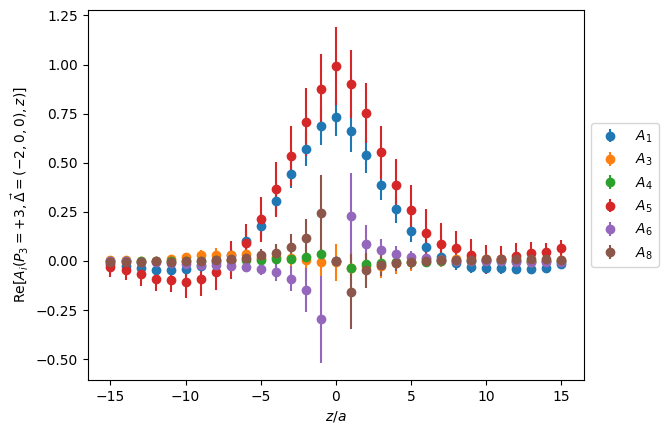

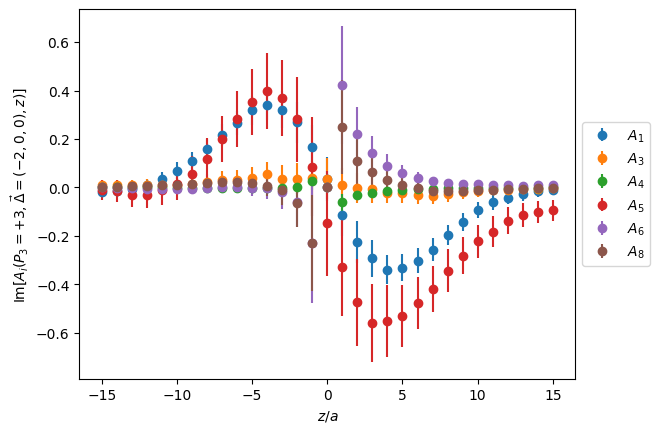

In [14]:
test_Ai_mean_real, test_Ai_err_real = quick_stats(np.array([np.real(Ais[z][3][(-2, 0, 0)]) for z in zs]), axis = 2)
test_Ai_mean_imag, test_Ai_err_imag = quick_stats(np.array([np.imag(Ais[z][3][(-2, 0, 0)]) for z in zs]), axis = 2)

i_real = [1,3,4,5,6,8]
plt.figure()
for i in range(6):
  plt.errorbar(zs, test_Ai_mean_real[:,i], yerr = test_Ai_err_real[:,i], fmt = 'o', label = r'$A_{}$'.format(i_real[i]))
plt.xlabel(r'$z/a$')
plt.ylabel(r'Re$[A_i(P_3 = +3, \vec{\Delta} = (-2,0,0), z)]$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure()
for i in range(6):
  plt.errorbar(zs, test_Ai_mean_imag[:,i], yerr = test_Ai_err_imag[:,i], fmt = 'o', label = r'$A_{}$'.format(i_real[i]))
plt.xlabel(r'$z/a$')
plt.ylabel(r'Im$[A_i(P_3 = +3, \vec{\Delta} = (-2,0,0), z)]$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

\[Your notes here\]

## Part 2: Symmetrization
The $A_i$ amplitudes are Lorentz invariant, so although we have written the arguments as $A_i(P_3, \vec{\Delta}, z)$ so far, the actual arguments are as follows:
$$A_i(z \cdot P, z \cdot \Delta, \Delta^2, z^2)$$

The matrix elements also have some specific symmetry properties. We want to obtain the amplitudes as just a function of, $z \in [0, 15a]$, as $P_3 = \pm 3$ and the different $\Delta$ are all equivalent up to some symmetries or anti-symmetries.
Let's walk through symmetrization to see what I mean.

### Step 2.1: $\Delta^2$ Symmetry
#### Task 2.1.1: What kind of symmetry do we have?
The independent variables for the amplitudes are $(z \cdot P, z \cdot \Delta, \Delta^2, z^2)$. We only have $\vec{\Delta}$ in the x- and y-directions, so how should we reduce the amplitudes across the different $\vec{\Delta}$?

Write your answer below.

\[Your notes here\]

#### Task 2.1.2: Write the code to do the $\Delta^2$ Symmetrization
In the cell below, write your code to make a new $A_i$ dictionary, where we have removed the $\vec{\Delta}$ argument.

Note: The current data setup for `Ais` is a nested dictionary full of numpy arrays. The incicies would be
```
Ais[z][P3][delta_tuple][i][j]
```
where `i` gives the index 0 to 5 which corresponds to $A_{1,3-6,8}$ and `j` corresponds to the sample index 0 to 499.

In [15]:
Ais_del_sym = {}
for z in zs:
  Ais_del_sym[z] = {}
  for P3 in [-3, 3]:
    Ais_del_sym[z][P3] = {}
    ### your code here, symmetrize over the different delta. ###


#### Task 2.1.3: Check the results
To test that you've made your dictionary correctly and that you've done the proper symmetrization, run the cell below to see if the plot looks correct.

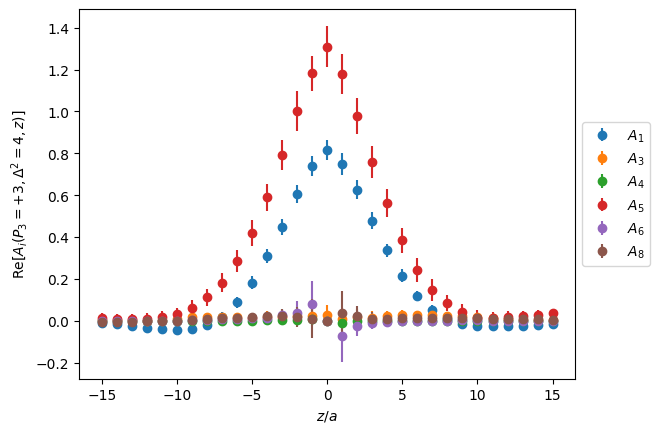

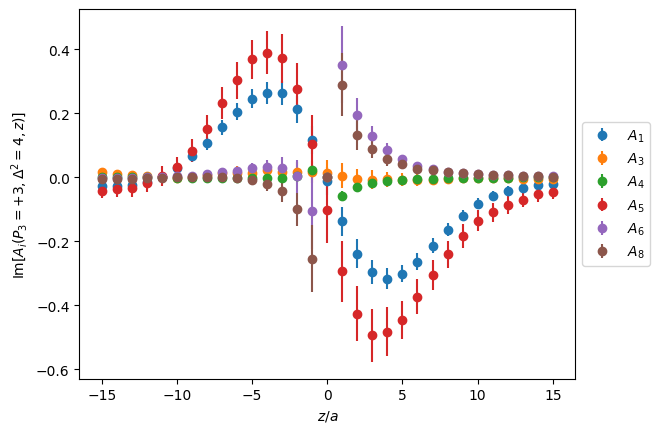

In [16]:
test_Ai_mean_real, test_Ai_err_real = quick_stats(np.array([np.real(Ais_del_sym[z][3]) for z in zs]), axis = 2)
test_Ai_mean_imag, test_Ai_err_imag = quick_stats(np.array([np.imag(Ais_del_sym[z][3]) for z in zs]), axis = 2)

i_real = [1,3,4,5,6,8]
plt.figure()
for i in range(6):
  plt.errorbar(zs, test_Ai_mean_real[:,i], yerr = test_Ai_err_real[:,i], fmt = 'o', label = r'$A_{}$'.format(i_real[i]))
plt.xlabel(r'$z/a$')
plt.ylabel(r'Re$[A_i(P_3 = +3, \Delta^2 = 4, z)]$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure()
for i in range(6):
  plt.errorbar(zs, test_Ai_mean_imag[:,i], yerr = test_Ai_err_imag[:,i], fmt = 'o', label = r'$A_{}$'.format(i_real[i]))
plt.xlabel(r'$z/a$')
plt.ylabel(r'Im$[A_i(P_3 = +3, \Delta^2 = 4, z)]$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

\[Your comments here\]

### Step 2.2 $P_3$ Symmetrization
The amplitudes have the following symmetries under $P_3 → -P_3$

$$
\begin{align}
A^*_1 (- z \cdot P, z \cdot \Delta, \Delta^2, z^2) & = A_1 (z \cdot P, z \cdot \Delta, \Delta^2, z^2) \, , \nonumber \\[0.2cm]
- A^*_2 (- z \cdot P, z \cdot \Delta, \Delta^2, z^2) & = A_2 (z \cdot P, z \cdot \Delta, \Delta^2, z^2) \, , \nonumber \\[0.2cm]
- A^*_3 (- z \cdot P, z \cdot \Delta, \Delta^2, z^2) & = A_3 (z \cdot P, z \cdot \Delta, \Delta^2, z^2) \, , \nonumber \\[0.2cm]
A^*_4 (- z \cdot P, z \cdot \Delta, \Delta^2, z^2) & = A_4 (z \cdot P, z \cdot \Delta, \Delta^2, z^2) \, , \nonumber \\[0.2cm]
A^*_5 (- z \cdot P, z \cdot \Delta, \Delta^2, z^2) & = A_5 (z \cdot P, z \cdot \Delta, \Delta^2, z^2) \, , \nonumber \\[0.2cm]
- A^*_6 (- z \cdot P, z \cdot \Delta, \Delta^2, z^2) & = A_6 (z \cdot P, z \cdot \Delta, \Delta^2, z^2) \, , \nonumber \\[0.2cm]
A^*_7 (- z \cdot P, z \cdot \Delta, \Delta^2, z^2) & = A_7 (z \cdot P, z \cdot \Delta, \Delta^2, z^2) \, , \nonumber \\[0.2cm]
A^*_8 (- z \cdot P, z \cdot \Delta, \Delta^2, z^2) & = A_8 (z \cdot P, z \cdot \Delta, \Delta^2, z^2) \, .
\end{align}
$$

#### Task 2.2.1: How do we use these relationships?
Brainstorm with your group on how you should take advantage of these relations to reduce the amplitudes to only depend on $|P_3|$ (which is a constant over all the data).

\[Your notes here\]

#### Task 2.2.2: Write the code for the $P_3$ Symmetrization
Write the code to average over $P_3 = \pm 3$, taking care of the proper symmetries in the text above.
I recommend taking advantage of `np.conj()` instead of trying to handle the real and imaginary components separately.

In [17]:
Ais_P_sym = {}

for z in zs:
  Ais_P_sym[z] = np.zeros((6, N_samples), dtype=complex)
  #write your code here. Symmetrize each amplitude over P_3 = +/- 3

#### Task 2.2.3: Check the results
To test that you've made your dictionary correctly and that you've done the proper symmetrization, run the cell below to see if the plot looks correct.

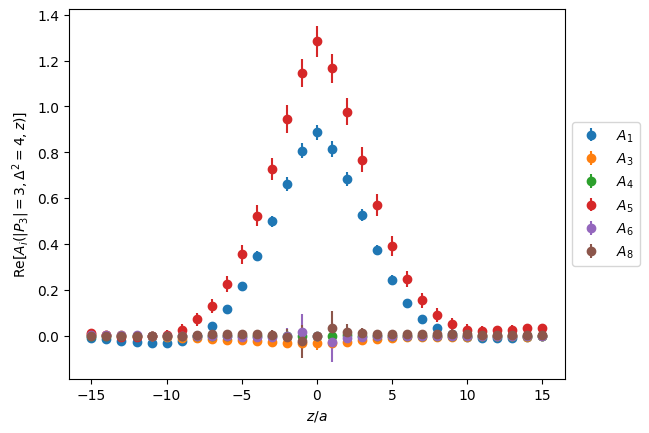

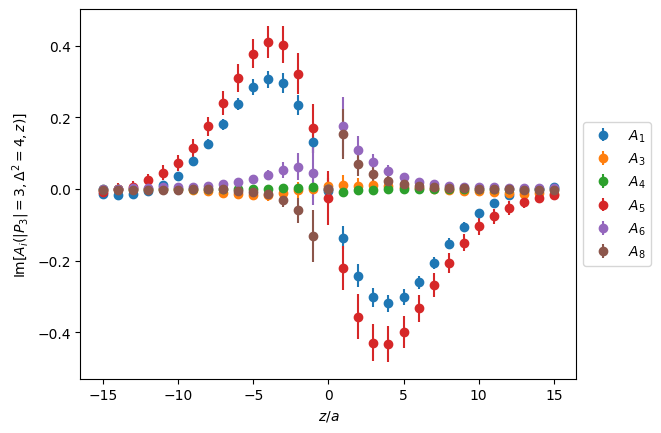

In [18]:
test_Ai_mean_real, test_Ai_err_real = quick_stats(np.array([np.real(Ais_P_sym[z]) for z in zs]), axis = 2)
test_Ai_mean_imag, test_Ai_err_imag = quick_stats(np.array([np.imag(Ais_P_sym[z]) for z in zs]), axis = 2)

i_real = [1,3,4,5,6,8]
plt.figure()
for i in range(6):
  plt.errorbar(zs, test_Ai_mean_real[:,i], yerr = test_Ai_err_real[:,i], fmt = 'o', label = r'$A_{}$'.format(i_real[i]))
plt.xlabel(r'$z/a$')
plt.ylabel(r'Re$[A_i(|P_3| = 3, \Delta^2 = 4, z)]$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure()
for i in range(6):
  plt.errorbar(zs, test_Ai_mean_imag[:,i], yerr = test_Ai_err_imag[:,i], fmt = 'o', label = r'$A_{}$'.format(i_real[i]))
plt.xlabel(r'$z/a$')
plt.ylabel(r'Im$[A_i(|P_3| = 3, \Delta^2 = 4, z)]$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Step 2.3: $z$ Symmetrization
The symmetry under $z \rightarrow -\bar{z}$ is given by

$$\begin{align}
A^*_1 (- \bar{z} \cdot \bar{P}, -\bar{z} \cdot \bar{\Delta}, \bar{\Delta}^2, \bar{z}^2) & = A_1 (z \cdot P, z \cdot \Delta, \Delta^2, z^2) \, , \nonumber \\[0.2cm]
- A^*_2 (- \bar{z} \cdot \bar{P}, -\bar{z} \cdot \bar{\Delta}, \bar{\Delta}^2, \bar{z}^2) & = A_2 (z \cdot P, z \cdot \Delta, \Delta^2, z^2) \, , \nonumber \\[0.2cm]
A^*_3 (- \bar{z} \cdot \bar{P}, -\bar{z} \cdot \bar{\Delta}, \bar{\Delta}^2, \bar{z}^2) & = A_3 (z \cdot P, z \cdot \Delta, \Delta^2, z^2) \, , \nonumber \\[0.2cm]
- A^*_4 (- \bar{z} \cdot \bar{P}, -\bar{z} \cdot \bar{\Delta}, \bar{\Delta}^2, \bar{z}^2) & = A_4 (z \cdot P, z \cdot \Delta, \Delta^2, z^2) \, , \nonumber \\[0.2cm]
A^*_5 (- \bar{z} \cdot \bar{P}, -\bar{z} \cdot \bar{\Delta}, \bar{\Delta}^2, \bar{z}^2) & = A_5 (z \cdot P, z \cdot \Delta, \Delta^2, z^2) \, , \nonumber \\[0.2cm]
- A^*_6 (- \bar{z} \cdot \bar{P}, -\bar{z} \cdot \bar{\Delta}, \bar{\Delta}^2, \bar{z}^2) & = A_6 (z \cdot P, z \cdot \Delta, \Delta^2, z^2) \, , \nonumber \\[0.2cm]
A^*_7 (- \bar{z} \cdot \bar{P}, -\bar{z} \cdot \bar{\Delta}, \bar{\Delta}^2, \bar{z}^2) & = A_7 (z \cdot P, z \cdot \Delta, \Delta^2, z^2) \, , \nonumber \\[0.2cm]
- A^*_8 (- \bar{z} \cdot \bar{P}, -\bar{z} \cdot \bar{\Delta}, \bar{\Delta}^2, \bar{z}^2) & = A_8 (z \cdot P, z \cdot \Delta, \Delta^2, z^2) \, .
\end{align}$$

We can use these symmetries to get the amplitudes at just $z \in [0, 15a]$, which is all we need.

#### Task 2.3.1: Write the code for $z$ Symmetrization
This should be very similar to how we did the code for the $P_3$ symmetrization, so no need to brainstorm, just write the code to do this!

We want to just have a numpy array that is indexed by $i \in [0,5]$ which correspond to $A_{1,3-6,8}$, $z$ and the sample index 0-499.

In [19]:
Ais_z_sym = np.zeros((6, 16, N_samples), dtype=complex)

zs_pos = np.arange(0,16)

# Make sure that we're not averaging over z = 0
for i in range(6):
  Ais_z_sym[i] = Ais_P_sym[0][i]

for z in zs_pos[1:]:
  ### write your code here. Symmetrize each amplitude over +/- z ###

#### Task 2.3.2: Check the Amplitudes
Run the code below to plots your aplitudes and check that everything had been done correctly. Compare your results to Figs. 5 and 6 of of [arXiv:2209.05373v2](https://arxiv.org/pdf/2209.05373).
Note that we have resampled the matrix elements, neglecting correlations, so the agreement will not be exact, but the general features should be the similar

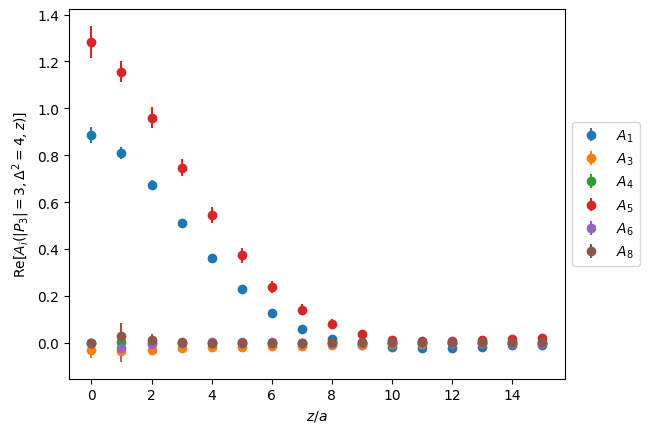

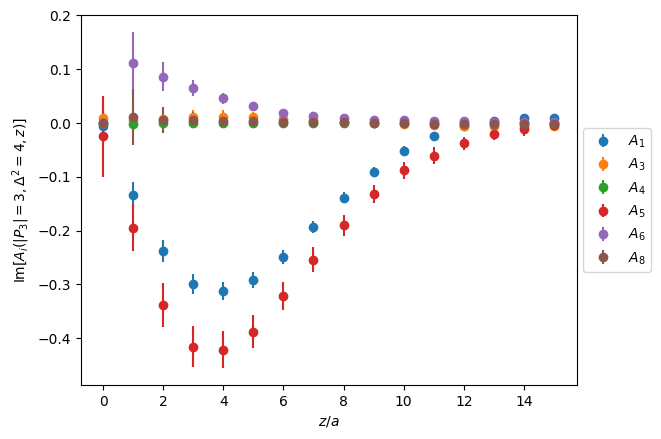

In [20]:
Ai_mean_real, Ai_err_real = quick_stats(np.real(Ais_z_sym), axis = 2)
Ai_mean_imag, Ai_err_imag = quick_stats(np.imag(Ais_z_sym), axis = 2)

i_real = [1,3,4,5,6,8]
plt.figure()
for i in range(6):
  plt.errorbar(zs_pos, Ai_mean_real[i], yerr = Ai_err_real[i], fmt = 'o', label = r'$A_{}$'.format(i_real[i]))
plt.xlabel(r'$z/a$')
plt.ylabel(r'Re$[A_i(|P_3| = 3, \Delta^2 = 4, z)]$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure()
for i in range(6):
  plt.errorbar(zs_pos, Ai_mean_imag[i], yerr = Ai_err_imag[i], fmt = 'o', label = r'$A_{}$'.format(i_real[i]))
plt.xlabel(r'$z/a$')
plt.ylabel(r'Im$[A_i(|P_3| = 3, \Delta^2 = 4, z)]$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

\[Your comments here\]

## Part 3: $H$ and $E$ quasi-GPDs
At zero skewness, the $H$ and $E$ spatial quasi-GPDs are defined
$$H(z) = A_1$$
and
$$E(z) = -A_1 + 2A_5 +2zP_3 A_6$$

Construct the $H$ and $E$ quasi-GPDs, get the mean and errors and plot the real and the imaginary parts.

### Step 3.1: Get the $H$ and $E$ quasi-GPDs
#### Task 3.1.1: Sample by sample
Construct $H$ and $E$ quasi-GPDs at each value of $z$ for each sample.
Put them into arrays of shape (16,N_samples) where the first axis is for $z \in [0,15a]$ and the second axis is for each sample.
Keep in mind that we have mostly denoted $P_3$ in units $2\pi/L$, so to get $zP_3$ as a unitless quantinity, we need to put $P_3$ into unit of $1/a$.

In [21]:
L = 32
P3_aInv = 3*2*np.pi/L

### Write your code here ###

#### Task 3.1.2: Plot the results
Run the cell below to make sure that we have constructed the $H$ and $E$ GPDs correctly.
Compare to the orange and red points in Figs. 8 and 9 of [arXiv:2209.05373v2](https://arxiv.org/pdf/2209.05373).
Note that we have resampled the matrix elements, neglecting correlations, so the agreement will not be exact, but the general features should be the similar

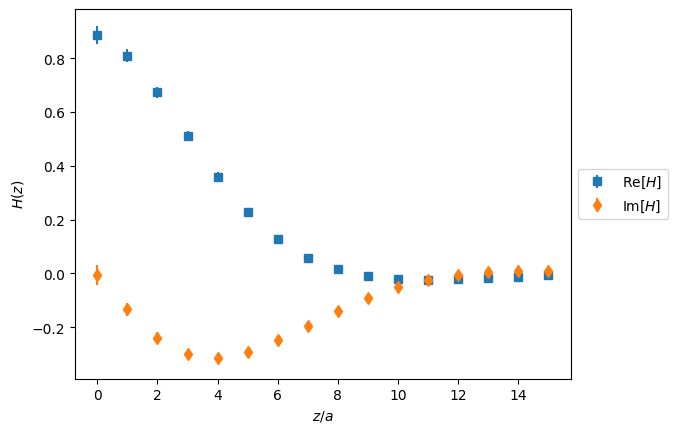

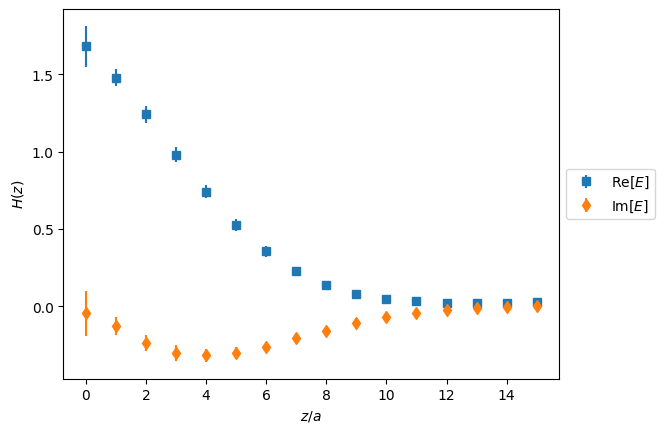

In [22]:
H_mean_real, H_err_real = quick_stats(np.real(H), axis = 1)
H_mean_imag, H_err_imag = quick_stats(np.imag(H), axis = 1)
E_mean_real, E_err_real = quick_stats(np.real(E), axis = 1)
E_mean_imag, E_err_imag = quick_stats(np.imag(E), axis = 1)



plt.figure()
plt.errorbar(zs_pos, H_mean_real, yerr = H_err_real, fmt = 's', label = r'Re$[H]$')
plt.errorbar(zs_pos, H_mean_imag, yerr = H_err_imag, fmt = 'd', label = r'Im$[H]$')
plt.xlabel(r'$z/a$')
plt.ylabel(r'$H(z)$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure()
plt.errorbar(zs_pos, E_mean_real, yerr = E_err_real, fmt = 's', label = r'Re$[E]$')
plt.errorbar(zs_pos, E_mean_imag, yerr = E_err_imag, fmt = 'd', label = r'Im$[E]$')
plt.xlabel(r'$z/a$')
plt.ylabel(r'$H(z)$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

\[Your comments here\]

----
# Part 4 (OPTIONAL): Fourier Transformations

In this section, we will explore some issues with how we obtain the momentum space quasi-GPDs.
How do we handle the fact that we only have a set of discrete points?
How do we handle that we only have data out to a finite $z$?

We will look into the solutions to these questions, but note that we have not renormalized our matrix elements, so our momentum space quasi-GPDs will not correspond to anything physical.
Renormalization will cause the long distance matrix elements to fall off more slowly and add even more noise, so any issues we see in this case will be exaggerated in a real scenario with renormalized matrix elements.

\[Add in the equation for the Fourier transform and some explanation\]

## Step 4.1: Interpolation
Since the Fourier transform of the matrix elements requires an integral over $z$, we need to interpolate the matrix elements.
At this point, we should treat the real and imaginary components separately.

### Task 4.1.1: Choose and apply an interpoator
Choose any type of interpolator. I recommend looking into the `scipy.interpolate` library and choosing.
Interpolate the real and imaginary components of the $E$ and $H$ matrix elements each separately.
Do this sample by sample.

In [22]:
### Your code here, load an interpolator from some module

### Your code here, build the interpolators from the real and imaginary H and E data, sample by sample

#### Task 4.1.2
Make a plot of the interpolations on top of the data.
See if your interpolation is working well.
Is it too choppy?
Are there oscillations?
Go back and refine your interpolator if you think either of these things are happening.

In [23]:
# you can make this more fine if you want
fine_zs = np.linspace(0,15,150)

### Your code here, generate lists of the interpolated H and E sample by sample

### Your code here, take the mean and error of the interpolated results

plt.figure()
plt.errorbar(zs_pos, H_mean_real, yerr = H_err_real, fmt = 's', label = r'Re$[H]$')
plt.errorbar(zs_pos, H_mean_imag, yerr = H_err_imag, fmt = 'd', label = r'Im$[H]$')
plt.plot(fine_zs,### your code here) #real part
plt.fill_between(fine_zs,### your code here) #real part
plt.plot(fine_zs,### your code here) #imag part
plt.fill_between(fine_zs,### your code here) #imag part
plt.xlabel(r'$z/a$')
plt.ylabel(r'$H(z)$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure()
plt.errorbar(zs_pos, E_mean_real, yerr = E_err_real, fmt = 's', label = r'Re$[E]$')
plt.errorbar(zs_pos, E_mean_imag, yerr = E_err_imag, fmt = 'd', label = r'Im$[E]$')
plt.plot(fine_zs,### your code here) #real part
plt.fill_between(fine_zs,### your code here) #real part
plt.plot(fine_zs,### your code here) #imag part
plt.fill_between(fine_zs,### your code here) #imag part
plt.xlabel(r'$z/a$')
plt.ylabel(r'$E(z)$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-23-3206e70cab99>, line 10)

## Step 4.2: Simple Truncated Fourier Transform
In this step, we want to compute the Fourier transform on the interpolations, and only go out to $z=15a$.

### Task 4.2.1: Consider Symmetries
The $H$ and $E$ GPDs are both symmetric in their real parts and anti-symmetric in the imaginary parts.
Think about how we can take advantage of this.

\[ Your notes here\]

### Task 4.2.2: Implement The Fourier Transform
Compute the truncated Fourier transform as an integral out to $z = 15a$ on your interpolations of the real and imaginary $H$ and $E$ GPDs.
Use whatever integration method you would like, as long as it is numerically converged.
Take advantage of the symmetries mentioned above.
Plot the results.

Obtain the quasi-GPDs at $x \in [0,1.5]$ with steps of $0.01$.

In [ ]:
from scipy.integrate import quad

xs = np.linspace(0,1.5,151)

### Your code here, compute the fourier transform ###

In [ ]:
## Plot your results

#Modify these if your data organization is different
quasi_H_mean, quasi_H_err = quick_stats(quasi_H, axis = 1)
quasi_E_mean, quasi_E_err = quick_stats(quasi_E, axis = 1)

plt.plot(xs, quasi_H_mean, color = 'tab:blue', label = r"$\widetilde{H}$")
plt.fill_between(xs,quasi_H_mean - quasi_H_err, quasi_H_mean+quasi_H_err, color = 'tab:blue', alpha = 0.5)
plt.plot(xs, quasi_E_mean, color = 'tab:orange', label = "$\widetilde{E}$")
plt.fill_between(xs,quasi_E_mean - quasi_E_err, quasi_E_mean+quasi_E_err, color = 'tab:orange', alpha = 0.5)

plt.xlabel(r'$x$')
plt.ylabel(r'$\widetilde{F}(x)$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Task 4.2.3: Group Discussion
Does the Fourier tranform look reasonable?
Would you consider it converged, meaning that if we added data from larger $z$, would the results be the same or different?

\[Some information on extrapolations\]

---
# Assignment Wrap-up

Please upload and/or share your in-class assignement according to your university lead-faculty's instruction.